<a href="https://colab.research.google.com/github/Lyawii/MachineLearning/blob/main/PW7_MachineLearning_JT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRATICAL WORK 7** : RNN

##  1. Load and prepare data


In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXA63MH/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXA63MH/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXA63MH/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])				          # Display training dataset metric
  plt.plot(history.history['val_'+metric], '')			# Display testing dataset metric
  plt.xlabel("Iterations")					                # x axis label
  plt.ylabel(metric)						                    # y axis label
  plt.legend([metric, 'val_'+metric])				        # Legend

In [3]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
X_train = np.empty(0,dtype=str)		# Preallocate empty strings array for X data (review text)
Y_train = np.empty(0,dtype=int)		# Preallocate empty integers array for Y data (labels)

for ex, lbl in train_dataset:
  X_train = np.append(X_train, ex.numpy())		# Add text data at the end of X array
  Y_train = np.append(Y_train, lbl.numpy())		# Add label data at the end of Y array

X_test = np.empty(0,dtype=str)		# Preallocate empty strings array for X data (review text)
Y_test = np.empty(0,dtype=int)		# Preallocate empty integers array for Y data (labels)

for ex, lbl in test_dataset:
  X_test = np.append(X_test, ex.numpy())		# Add text data at the end of X array
  Y_test = np.append(Y_test, lbl.numpy())		# Add label data at the end of Y array

In [6]:
# Merge Training/Testing data into one full set
X = np.hstack((X_train,X_test))		# Text data X
Y = np.hstack((Y_train,Y_test))		# Labels data Y	

# Separate classes, by locating array elements of each class (Y=0 and Y=1)
idx0 = np.where(Y==0)		# 1-st class array indices (Y = 0)
idx1 = np.where(Y==1)		# 2-nd class array indices (Y = 1)
X0 = X[idx0]		      	# 1-st class text data
Y0 = Y[idx0]				    # 1-st class labels data
X1 = X[idx1]				    # 2-nd class text data
Y1 = Y[idx1]				    # 2-nd class labels data

# Merge data again with different ratio of 1-st and 2-nd class data (number of entries is the last index)
X = np.hstack((X0[idx0[0][0:9000]],X1[idx1[0][0:1000]]))	# Text data
Y =	np.hstack((Y0[idx0[0][0:9000]],Y1[idx1[0][0:1000]]))							# Labels data

# Now You can split data set in training/testing parts (see PE05)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## 2. Perform encoding for RNN

In [7]:
from keras.layers import TextVectorization

VOCAB_SIZE = 1000
encoder = TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])

['' '[UNK]' 'the' 'a' 'and' 'of' 'to' 'is' 'in' 'this' 'i' 'it' 'that'
 'br' 'was' 'movie' 'for' 'as' 'but' 'with']


## 3. Design RNN and train it

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

model = Sequential()
model.add(encoder)
model.add(Embedding(input_dim=len(vocab), output_dim=64, mask_zero=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [9]:
from keras.optimizers import Adam
optAdam = Adam(1e-4)

from keras.losses import BinaryCrossentropy
lossFun = BinaryCrossentropy(from_logits=True)

model.compile(loss=lossFun, optimizer=optAdam, metrics=['accuracy'])

# Train neural network

historyBalanced = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test), validation_steps=30)

Epoch 1/10
250/250 [==============================] - 31s 77ms/step - loss: 0.4228 - accuracy: 0.8997 - val_loss: 0.3213 - val_accuracy: 0.9010
Epoch 2/10
250/250 [==============================] - 17s 70ms/step - loss: 0.3196 - accuracy: 0.8997 - val_loss: 0.3105 - val_accuracy: 0.9010
Epoch 3/10
250/250 [==============================] - 16s 65ms/step - loss: 0.2900 - accuracy: 0.8997 - val_loss: 0.2644 - val_accuracy: 0.9010
Epoch 4/10
250/250 [==============================] - 16s 65ms/step - loss: 0.2352 - accuracy: 0.8997 - val_loss: 0.2228 - val_accuracy: 0.9010
Epoch 5/10
250/250 [==============================] - 17s 66ms/step - loss: 0.2111 - accuracy: 0.9001 - val_loss: 0.2168 - val_accuracy: 0.9015
Epoch 6/10
250/250 [==============================] - 17s 66ms/step - loss: 0.1826 - accuracy: 0.9114 - val_loss: 0.2011 - val_accuracy: 0.9110
Epoch 7/10
250/250 [==============================] - 16s 66ms/step - loss: 0.1657 - accuracy: 0.9324 - val_loss: 0.2002 - val_accuracy:

In [10]:
modelEq = Sequential()
modelEq.add(encoder)
modelEq.add(Embedding(input_dim=len(vocab), output_dim=64, mask_zero=True))
modelEq.add(Bidirectional(LSTM(64)))
modelEq.add(Dense(64,activation='relu'))
modelEq.add(Dense(1))

modelEq.compile(loss=lossFun, optimizer=optAdam, metrics=['accuracy'])
UnbalancedEqualsClassWeights = {0: 1, 1: 1}

historyUnbalEq = modelEq.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test), validation_steps=30, class_weight=UnbalancedEqualsClassWeights)

Epoch 1/10
250/250 [==============================] - 26s 75ms/step - loss: 0.3520 - accuracy: 0.8997 - val_loss: 0.3122 - val_accuracy: 0.9010
Epoch 2/10
250/250 [==============================] - 16s 66ms/step - loss: 0.2810 - accuracy: 0.8997 - val_loss: 0.2377 - val_accuracy: 0.9010
Epoch 3/10
250/250 [==============================] - 16s 66ms/step - loss: 0.2067 - accuracy: 0.9069 - val_loss: 0.2093 - val_accuracy: 0.9090
Epoch 4/10
250/250 [==============================] - 17s 66ms/step - loss: 0.1724 - accuracy: 0.9336 - val_loss: 0.2171 - val_accuracy: 0.9180
Epoch 5/10
250/250 [==============================] - 17s 66ms/step - loss: 0.1581 - accuracy: 0.9389 - val_loss: 0.2052 - val_accuracy: 0.9155
Epoch 6/10
250/250 [==============================] - 18s 70ms/step - loss: 0.1509 - accuracy: 0.9420 - val_loss: 0.2194 - val_accuracy: 0.9130
Epoch 7/10
250/250 [==============================] - 17s 67ms/step - loss: 0.1452 - accuracy: 0.9438 - val_loss: 0.2094 - val_accuracy:

In [11]:
modelDif = Sequential()
modelDif.add(encoder)
modelDif.add(Embedding(input_dim=len(vocab), output_dim=64, mask_zero=True))
modelDif.add(Bidirectional(LSTM(64)))
modelDif.add(Dense(64,activation='relu'))
modelDif.add(Dense(1))

modelDif.compile(loss=lossFun, optimizer=optAdam, metrics=['accuracy'])
UnbalancedDiffClassWeights = {0: 0.5, 1: 5}

historyUnbalDiff = modelDif.fit(X_train, Y_train, epochs=10, validation_data=(X_test,Y_test), validation_steps=30, class_weight=UnbalancedDiffClassWeights)

Epoch 1/10
250/250 [==============================] - 25s 74ms/step - loss: 0.6496 - accuracy: 0.8919 - val_loss: 0.6887 - val_accuracy: 0.8880
Epoch 2/10
250/250 [==============================] - 16s 65ms/step - loss: 0.4631 - accuracy: 0.8346 - val_loss: 0.5571 - val_accuracy: 0.7705
Epoch 3/10
250/250 [==============================] - 17s 67ms/step - loss: 0.3531 - accuracy: 0.8576 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 4/10
250/250 [==============================] - 17s 66ms/step - loss: 0.2980 - accuracy: 0.8796 - val_loss: 0.3514 - val_accuracy: 0.8645
Epoch 5/10
250/250 [==============================] - 17s 66ms/step - loss: 0.2699 - accuracy: 0.8919 - val_loss: 0.3254 - val_accuracy: 0.8845
Epoch 6/10
250/250 [==============================] - 16s 66ms/step - loss: 0.2458 - accuracy: 0.9039 - val_loss: 0.3909 - val_accuracy: 0.8675
Epoch 7/10
250/250 [==============================] - 16s 66ms/step - loss: 0.2284 - accuracy: 0.9097 - val_loss: 0.3935 - val_accuracy:

## 4. Display performance metrics & confusion Matrix


In [12]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_acc)

# Make predictions for X_test
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0)*1

from sklearn.metrics import confusion_matrix, classification_report
print("Classification report: \n", classification_report(Y_test, Y_pred))
print("Confusion matrix: \n", confusion_matrix(Y_test, Y_pred))

63/63 [==============================] - 2s 36ms/step - loss: 0.2059 - accuracy: 0.9200
Test Loss:  0.20586077868938446
Test Accuracy:  0.9200000166893005
63/63 [==============================] - 4s 35ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      1802
           1       0.60      0.52      0.56       198

    accuracy                           0.92      2000
   macro avg       0.77      0.74      0.76      2000
weighted avg       0.91      0.92      0.92      2000

Confusion matrix: 
 [[1733   69]
 [  95  103]]


In [13]:
test_lossEq, test_accEq = modelEq.evaluate(X_test, Y_test)
print('Test Loss: ', test_lossEq)
print('Test Accuracy: ', test_accEq)

# Make predictions for X_test
Y_predEq = modelEq.predict(X_test)
Y_predEq = (Y_predEq > 0)*1

from sklearn.metrics import confusion_matrix, classification_report
print("Classification report: \n", classification_report(Y_test, Y_predEq))
print("Confusion matrix: \n", confusion_matrix(Y_test, Y_predEq))

63/63 [==============================] - 2s 36ms/step - loss: 0.2164 - accuracy: 0.9185
Test Loss:  0.21642978489398956
Test Accuracy:  0.9185000061988831
63/63 [==============================] - 5s 35ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1802
           1       0.57      0.48      0.52       198

    accuracy                           0.91      2000
   macro avg       0.76      0.72      0.74      2000
weighted avg       0.91      0.91      0.91      2000

Confusion matrix: 
 [[1729   73]
 [ 102   96]]


In [14]:
test_lossDif, test_accDif = modelDif.evaluate(X_test, Y_test)
print('Test Loss: ', test_lossDif)
print('Test Accuracy: ', test_accDif)

# Make predictions for X_test
Y_predDif = modelDif.predict(X_test)
Y_predDif = (Y_predDif > 0)*1

from sklearn.metrics import confusion_matrix, classification_report
print("Classification report: \n", classification_report(Y_test, Y_predDif))
print("Confusion matrix: \n", confusion_matrix(Y_test, Y_predDif))

63/63 [==============================] - 2s 36ms/step - loss: 0.2823 - accuracy: 0.9020
Test Loss:  0.28227049112319946
Test Accuracy:  0.9020000100135803
63/63 [==============================] - 4s 35ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      1802
           1       0.47      0.71      0.57       198

    accuracy                           0.89      2000
   macro avg       0.72      0.81      0.75      2000
weighted avg       0.92      0.89      0.90      2000

Confusion matrix: 
 [[1646  156]
 [  58  140]]


## 5. Display plots of metrics (Accuracy and Loss)

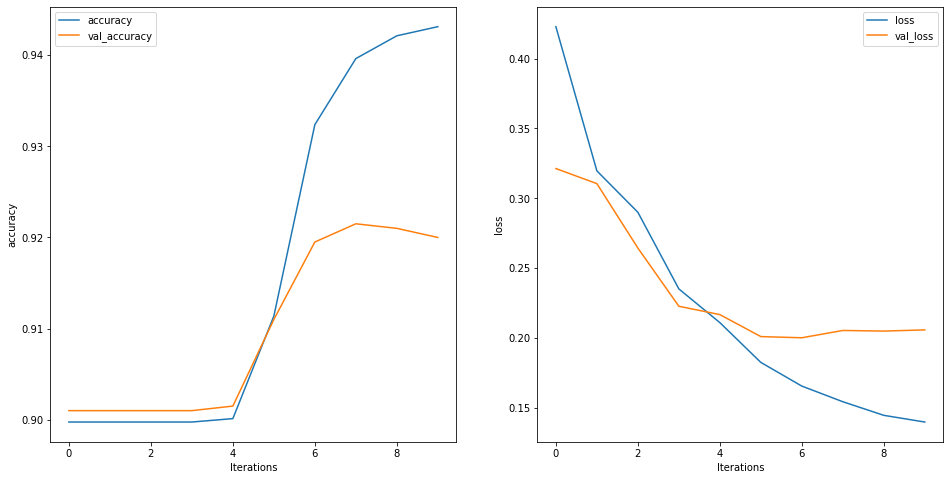

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_graphs(historyBalanced, 'accuracy')
plt.subplot(122)
plot_graphs(historyBalanced, 'loss')

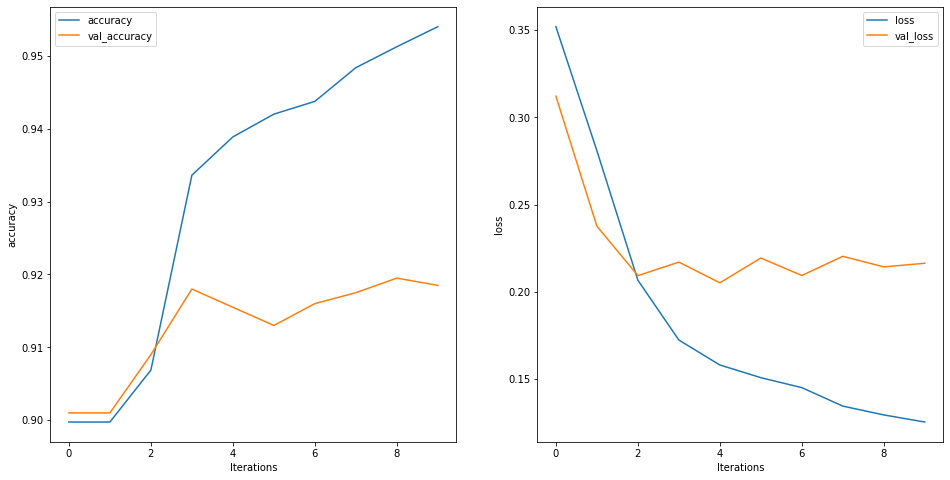

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_graphs(historyUnbalEq, 'accuracy')
plt.subplot(122)
plot_graphs(historyUnbalEq, 'loss')

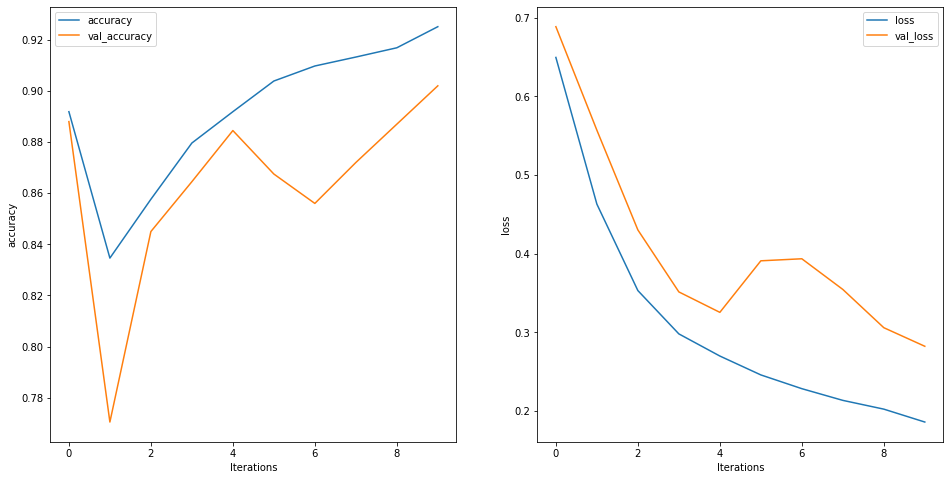

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_graphs(historyUnbalDiff, 'accuracy')
plt.subplot(122)
plot_graphs(historyUnbalDiff, 'loss')

**END PRATICAL WORK**